## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2020-12-15 19:40:39--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2020-12-15 19:40:39 (8.84 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

import string 
import numpy as np

tmp = '';
for st in text:
  tmp += st
text = tmp.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
token_to_idx = {t:i for i, t in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {i:t for i, t in enumerate(tokens)}

In [7]:
enc_text = np.array([token_to_idx[ch] for ch in text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
def to_one_hot(idxes, n_labels):
    one_hot = np.zeros((np.multiply(*idxes.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), idxes.flatten()] = 1.0
    one_hot = one_hot.reshape((*idxes.shape, n_labels))
    
    return one_hot

In [9]:
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length

    n_batches = len(arr)//batch_size_total
    
    assert n_batches > 0, "Array is too small: %r, while total batch size is %r" % (len(arr), batch_size_total)
    
    # Throwing away extra chars
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))
    
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]

        y = np.zeros_like(x)
        #shifting by one char
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [10]:
 def plot_loss(loss_avg):
    clear_output(True)
    plt.plot(loss_avg,label='loss')
    plt.legend()
    plt.show()

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F

class VanillaRNN(nn.Module):
   
    def __init__(self, num_tokens=len(tokens), tokens = tokens, hidden_num = 512, layer_num = 1, drop_prob = 0.5):
        super(self.__class__,self).__init__()
        self.num_layers = layer_num
        self.tokens = tokens
        self.h_num = hidden_num
        self.rnn_update = nn.RNN(len(tokens), hidden_num, batch_first = True, bidirectional = False)
        self.dropout = nn.Dropout(p = drop_prob, inplace = False)
        self.final = nn.Linear(hidden_num, len(tokens))
        
    def forward(self, x, h_prev):
      
        r_out, h_next = self.rnn_update(x, h_prev)
        r_out = self.dropout(r_out)
        r_out = r_out.contiguous().view(-1, self.h_num)
        r_out = self.final(r_out)
    
        return r_out, h_next
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data

        hidden = weight.new(self.num_layers, batch_size, self.h_num).zero_()
        return hidden

In [12]:
def train(model, data, num_epochs = 10, batch_size = 64, seq_length = 60, l_rate = 0.002, val_frac = 0.2):
  model.train()
  
  opt = torch.optim.Adam(model.parameters(), lr = l_rate)
  loss = nn.CrossEntropyLoss()
  val_idx = int(len(data)*(1-val_frac))
  train_data, val_data = data[:val_idx], data[val_idx:]
  
  model.cuda()
  
  total_train_loss = []
  total_val_loss = []
  for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    model.train()
    for x, y in get_batches(train_data, batch_size, seq_length):
      h = model.initial_state(batch_size)
      x = to_one_hot(x, len(tokens))
      inp, target = torch.FloatTensor(x), torch.FloatTensor(y)
      inp, target = inp.cuda(), target.cuda()
      
      model.zero_grad()
      outp, h = model(inp, h)
      train_loss = loss(outp, target.view(batch_size*seq_length).long())
      train_loss.backward()
      train_losses.append(train_loss.item())
      opt.step()
    model.eval()

    for x, y in get_batches(val_data, batch_size, seq_length):
      h = model.initial_state(batch_size)
      x = to_one_hot(x, len(tokens))
      inp, target = torch.FloatTensor(x), torch.FloatTensor(y)
      inp, target = inp.cuda(), target.cuda()
      
      outp, h = model(inp, h)
      v_loss = loss(outp, target.view(batch_size*seq_length).long())
      val_losses.append(v_loss.item())

    total_train_loss.append(np.mean(train_losses))
    total_val_loss.append(np.mean(val_losses))
    print("Epoch # {:d}".format(epoch),
          "Train loss is {:.4f}".format(total_train_loss[-1]),
          "Validation loss is {:.4f}".format(total_val_loss[-1]))
  return total_train_loss, total_val_loss

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = VanillaRNN(tokens)
model.to(device)
print(model)

batch_size = 128
seq_length = 120
n_epochs = 100 

train_losses, val_losses = train(model, enc_text, num_epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, l_rate=0.002)


VanillaRNN(
  (rnn_update): RNN(38, 512, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (final): Linear(in_features=512, out_features=38, bias=True)
)
Epoch # 0 Train loss is 3.3390 Validation loss is 3.0251
Epoch # 1 Train loss is 3.0001 Validation loss is 2.9465
Epoch # 2 Train loss is 2.9394 Validation loss is 2.8927
Epoch # 3 Train loss is 2.8837 Validation loss is 2.8380
Epoch # 4 Train loss is 2.8148 Validation loss is 2.7673
Epoch # 5 Train loss is 2.8155 Validation loss is 2.8258
Epoch # 6 Train loss is 2.8725 Validation loss is 2.7427
Epoch # 7 Train loss is 2.7213 Validation loss is 2.7591
Epoch # 8 Train loss is 2.7315 Validation loss is 2.6559
Epoch # 9 Train loss is 2.6328 Validation loss is 2.5821
Epoch # 10 Train loss is 2.5662 Validation loss is 2.5138
Epoch # 11 Train loss is 2.5065 Validation loss is 2.4569
Epoch # 12 Train loss is 2.4457 Validation loss is 2.4080
Epoch # 13 Train loss is 2.3960 Validation loss is 2.3570
Epoch # 14 Train loss is 2.3470

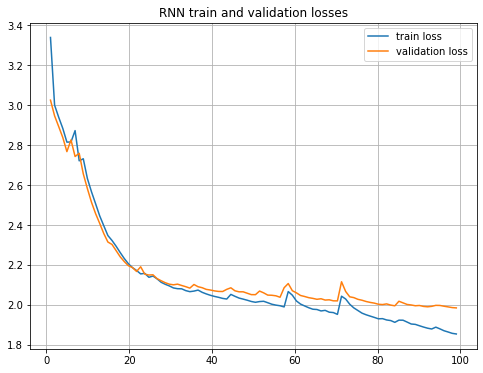

In [14]:
from matplotlib import pyplot as plt

plt.figure(4, figsize = (8, 6))
_plot = plt.plot(np.linspace(1,n_epochs-1,n_epochs), train_losses, np.linspace(1,n_epochs-1,n_epochs), val_losses)
plt.legend(_plot, ("train loss", "validation loss"))
plt.title("RNN train and validation losses")
plt.grid()

In [15]:
def get_char(model, char, h = None, temperature=1.0):
  x = np.array([[token_to_idx[char]]])
  x = to_one_hot(x, len(model.tokens))
  inp = torch.FloatTensor(x)
  inp = inp.cuda()

  out, h = model(inp, h)
  
  p = F.softmax(out/temperature, dim=1).data
  p = p.cpu() 
  
  top_ch = np.arange(len(model.tokens))
  p = p.numpy().squeeze()
  char = np.random.choice(top_ch, p=p/p.sum())
  
  return idx_to_token[char], h

In [16]:
def generate_sample(max_length, model, seed_phrase=' ', temperature=1.0, h = None):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    x_sequence = to_one_hot(x_sequence, len(model.tokens))
    x_sequence = torch.from_numpy(x_sequence)
    x_sequence.cuda()
    hid_state = model.initial_state(batch_size=1)
    
    chars = [ch for ch in seed_phrase]
    for ch in seed_phrase:
      char, h = get_char(model, ch, h)
    chars.append(char)
    
    for _ in range(max_length - len(seed_phrase)):
        char, h = get_char(model, chars[-1], h)
        chars.append(char)
    return ''.join(chars)

In [17]:
# An example of generated text.
print(generate_sample(500, model, seed_phrase="hide my will in thine?", temperature=0.2))

hide my will in thine?
  un tham hig lay loven mo, prait,
  in ip eat dort bu
m  far the sam ir prithr igwondgathion thy.

  xvivi

  o! is in of ree; mo noll mion, acknot in tue llate th yem fios wiit thay tyes'cr, not, and chely dumy dearewi's cce:
  aut thak sthonghend s and loves fors, lown's prieds and thee,
  thae thoud brust tooks al ;os se riast of co arind-
 arne, and the towe:
  on that baine d heqriende thetswred in thy heruri semingis wagrs of me, whech efares.
   of andis,
  in chl y


Получилось не очень похоже на Шекспира, но всё-таки можно заметить несколько английских слов.  
В основном, это короткие слова, сгенерировать имеющее смысл слово длиной более 6 символ сетка не может.  
Примечательно, что сетка генерит "номера" сонетов.


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [18]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), tokens = tokens, hidden_num = 512, layer_num = 1, drop_prob = 0.5):
        super(self.__class__,self).__init__()
        self.num_layers = layer_num
        self.tokens = tokens
        self.h_num = hidden_num
        self.rnn_update = nn.LSTM(len(tokens), hidden_num, batch_first = True, bidirectional = False)
        self.dropout = nn.Dropout(p = drop_prob, inplace = False)
        self.final = nn.Linear(hidden_num, len(tokens))
        
    def forward(self, x, h_prev):
        r_out, h_next = self.rnn_update(x, h_prev)
        r_out = self.dropout(r_out)
        r_out = r_out.contiguous().view(-1, self.h_num)
        r_out = self.final(r_out)
        return r_out, h_next

    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden_and_c = (weight.new(self.num_layers, batch_size, self.h_num).zero_(),
                    weight.new(self.num_layers, batch_size, self.h_num).zero_())
        return hidden_and_c

In [20]:
lstm = LSTM(tokens)
print(lstm)

batch_size = 128
seq_length = 150
n_epochs = 120

lstm_train_losses, lstm_val_losses = train(lstm, enc_text, num_epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, l_rate=0.0015)

LSTM(
  (rnn_update): LSTM(38, 512, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (final): Linear(in_features=512, out_features=38, bias=True)
)
Epoch # 0 Train loss is 3.5373 Validation loss is 3.5897
Epoch # 1 Train loss is 3.3003 Validation loss is 3.0519
Epoch # 2 Train loss is 3.0690 Validation loss is 3.0583
Epoch # 3 Train loss is 3.0513 Validation loss is 3.0046
Epoch # 4 Train loss is 2.9959 Validation loss is 2.9681
Epoch # 5 Train loss is 2.9816 Validation loss is 2.9681
Epoch # 6 Train loss is 2.9759 Validation loss is 2.9584
Epoch # 7 Train loss is 2.9650 Validation loss is 2.9536
Epoch # 8 Train loss is 2.9609 Validation loss is 2.9516
Epoch # 9 Train loss is 2.9577 Validation loss is 2.9481
Epoch # 10 Train loss is 2.9535 Validation loss is 2.9443
Epoch # 11 Train loss is 2.9503 Validation loss is 2.9414
Epoch # 12 Train loss is 2.9482 Validation loss is 2.9383
Epoch # 13 Train loss is 2.9431 Validation loss is 2.9346
Epoch # 14 Train loss is 2.9403 Vali

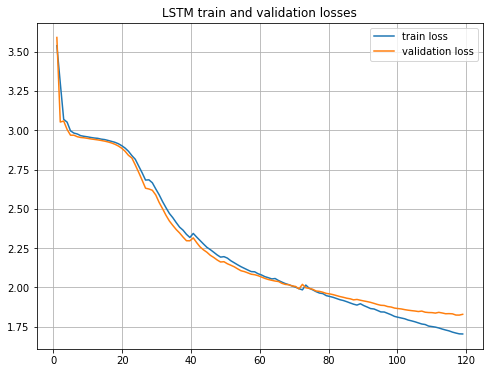

In [21]:
plt.figure(5, figsize = (8, 6))
_plot2 = plt.plot(np.linspace(1,n_epochs-1,n_epochs), lstm_train_losses, np.linspace(1,n_epochs-1,n_epochs), lstm_val_losses)
plt.legend(_plot2, ("train loss", "validation loss"))
plt.title("LSTM train and validation losses")
plt.grid()

Финальный loss стал лучше

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [23]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
  print("Generating text for temperature ", temp)
  print("=============================================")
  print(generate_sample(500, lstm, seed_phrase="hide my will in thine?", temperature=temp))
  print("=============================================")

Generating text for temperature  0.1
hide my will in thine?
  the shares ow ougs cinis if um shasu,
   sail the than mecins fortese tome himeg in now.

  lxiv

  o! that make concee, whet ir hom preewhtr.
  g act what sowel- ull my peant night
  my kent ro doun you worth tree,
  and hith, omy so mond enot troungre.
  ' hin mo pat ans thy greas rneis do that to of, comseed,
  and follengawe tu me covment anke:
  that opsbent be firls wher berachea owe mwild show dithst do fros, and the efriks af exprick of my tliok:
    feaf yor ay m
Generating text for temperature  0.2
hide my will in thine?
  o! mean
  as thay mekl me when eanti gre.
   -
' recver at shad con.
'  ives proast shate in yes of your foor,
  cleod'd, ah the sertint this thee cenvand fart of your fies hichs eofer,
  on the dist be to artever  cons in the irses.
  o but in nhis love o thy love with tase-
  the yet the wror sepman, lover enrelfor whale enam'd,
  pand if th forrowist whes im lase, to thie porets eades hay roth

В целом заметно лучше, чем RNN.
Теперь строчки примерно одинаковой длины, у RNN с этим была беда.  
Подавляющее большинство слов хотя бы выглядят как анлгийские, при T <= 1.0 очень много имеющих смысл слов.  
При увеличении температуры появляется больше непонятных комбинаций букв.  
Конечно, до полноценных стихов далеко: нет ни смысла, ни рифмы.
Думаю, что для того, чтобы сетка научилась рифмовать, нужно, чтобы seq_length был порядка трех-четырех строк в исходном тексте. Еще можно заметить, что слегка переобученная модель генерирует более человекоподобные тексты. И это понятно: когда модель переобучается, то она скорее выдает цитаты, чем генерирует что-то своё.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
%pwd

'/content'

In [ ]:
MODEL_PATH = "/content/gdrive/My Drive/мл лаба2/мое/LSTM_Shakespear.pt"

torch.save(lstm.state_dict(), MODEL_PATH)

In [ ]:
loaded_lstm = LSTM(tokens)
loaded_lstm.load_state_dict(torch.load(MODEL_PATH))
loaded_lstm.eval()
loaded_lstm.to(device)

print(generate_sample(500, loaded_lstm, seed_phrase="hide my will in thine?", temperature=0.5))

hide my will in thine?
   hehe velimy touftee: a makile the  bork:
  bo see, nit se and thin which forof ot me.
    thes wor fors respop't at beauty groshlight;
  thim siilds anver's wich maryoi lovely sare,
  shere or those lode ublighto solf deir mite,
   han with pridut)st of my somi-keod duth eils me.
   lewers in the hinry my meromy call deere.
  k weiine may theiuday as doth my grows
  to ceart, though fay torceevandelt;
  and for thy brait
  that i hal dy be dost is is al, than thee.
  a d


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)